# Classifying Developmental Outcome
In this notebook we will be testing various ML classifiers in how well they can forward predict developmental outcome based on: the whole feature set and a selected feature set based on correlations with neural and somitic module scores.

In [1]:
import organoid_prediction_python as opp
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

home_directory = r"C:\Users\savill\OneDrive\Documents\PhD Jesse\Embryonic_organoid_prediction\Processing dataset for Paper\TLS_2D_morphostate_investigation/"
table_location = home_directory + "tabular_data"

timecourse_data = pd.read_csv(f"{table_location}/All_Samples_Feature_Space_All_Features_48h,72h,96h_Normalised_per_Timepoint.csv")
timecourse_data

,Run,Plate,ID,048h_raw_BF_AreaShape_area,048h_raw_BF_AreaShape_aspect_ratio,048h_raw_BF_AreaShape_axis_major_length,048h_raw_BF_AreaShape_axis_minor_length,048h_raw_BF_AreaShape_eccentricity,048h_raw_BF_AreaShape_feret_diameter_max,048h_raw_BF_AreaShape_perimeter,...,096h_str_BF_AreaShape_moments_hu_1,096h_str_BF_AreaShape_moments_hu_2,096h_str_BF_AreaShape_moments_hu_3,096h_str_BF_AreaShape_moments_hu_4,096h_str_BF_AreaShape_moments_hu_5,096h_str_BF_AreaShape_moments_hu_6,096h_str_BF_AreaShape_orientation,096h_str_BF_AreaShape_perimeter,096h_str_CH_AreaShape_Bra_MajorAxis_Polarisation,096h_str_CH_AreaShape_Bra_MinorAxis_Polarisation
0,RR,1,A1,0.754091,-0.889636,0.132588,1.204628,-1.000051,0.007074,0.615519,...,-0.769984,-0.768314,-0.188818,-0.081040,-0.108285,-0.018937,0.218694,0.485603,-0.237483,0.204173
1,RR,1,A2,-0.783470,-1.252670,-1.238409,0.003129,-1.752936,-1.131530,-0.724230,...,-0.587974,0.518118,-0.142104,-0.080919,-0.108023,0.017986,-1.310831,-0.276812,-0.930821,1.071650
2,RR,1,A3,1.636441,-0.184192,1.186196,1.565451,-0.008740,1.127225,1.795347,...,-0.724302,-0.679043,-0.186519,-0.081045,-0.108504,-0.019001,-0.638784,0.014028,0.406917,-0.068697
3,RR,1,A4,-0.525754,-0.513477,-0.672134,-0.202863,-0.422446,-0.849309,-0.402853,...,0.276192,-0.326314,0.038707,-0.073034,-0.013521,0.038021,0.362758,0.652506,0.992505,-0.551399
4,RR,1,A5,0.537872,-0.248943,0.294790,0.612413,-0.084969,0.059492,0.498737,...,0.544892,-0.696050,-0.161387,-0.081127,-0.113141,-0.013480,-0.324894,-1.090064,0.285818,-0.643907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,TR,2,H8,-0.342295,-0.103644,-0.319022,-0.266071,0.083062,-0.511010,-0.233997,...,-0.240030,1.252083,-0.031233,-0.076766,-0.095753,0.232280,-0.531978,0.936472,-1.056426,0.770934
763,TR,2,H9,-0.925432,1.281638,-0.116354,-1.536867,1.304509,-0.330223,-1.009869,...,-0.010842,0.858318,-0.018204,-0.084586,-0.137911,0.247706,0.371618,1.965908,0.143556,0.712064
764,TR,2,H10,-1.873304,-1.279234,-2.131125,-1.049808,-1.821515,-2.016265,-1.929328,...,-0.454779,1.044578,-0.117763,-0.082320,-0.115499,0.052699,0.177291,1.923294,-1.128242,-0.816051
765,TR,2,H11,-2.408392,-0.915375,-2.411391,-1.803167,-1.045366,-2.414625,-2.306480,...,1.523053,0.369209,0.161155,-0.101456,-0.309307,0.338411,-0.341009,1.652660,-0.982778,1.840169


In [8]:
neural_corr_feature_table = pd.read_csv(f"{table_location}/ms_cor_features_120h_neural_score_fdr_5.csv")
somitic_corr_feature_table = pd.read_csv(f"{table_location}/ms_cor_features_120h_somitic_score_fdr_5.csv")
all_corr_feats = list(set(somitic_corr_feature_table["Unnamed: 0"].to_numpy()[:-1]).union(set(neural_corr_feature_table["Unnamed: 0"].to_numpy()[:-1])))
all_corr_feats = sorted([feat[1:] for feat in all_corr_feats])
len(all_corr_feats)

60

Set the features that we will include in each dataset

In [3]:
all_96h_feats = [
    '096h_raw_BF_AreaShape_area', '096h_raw_BF_AreaShape_aspect_ratio',
    '096h_raw_BF_AreaShape_axis_major_length',
    '096h_raw_BF_AreaShape_axis_minor_length',
    '096h_raw_BF_AreaShape_eccentricity',
    '096h_raw_BF_AreaShape_feret_diameter_max',
    '096h_raw_BF_AreaShape_perimeter',
    '096h_raw_BF_AreaShape_solidity',
    '096h_raw_CH_AreaShape_Bra_AreaFraction',
    '096h_raw_CH__bf_mask_Intensity_IntegratedIntensity',
    '096h_raw_CH__bf_mask_Intensity_IntegratedIntensityEdge',
    '096h_raw_CH__bf_mask_Intensity_LowerQuartileIntensity',
    '096h_raw_CH__bf_mask_Intensity_MADIntensity',
    '096h_raw_CH__bf_mask_Intensity_MassDisplacement',
    '096h_raw_CH__bf_mask_Intensity_MaxIntensity',
    '096h_raw_CH__bf_mask_Intensity_MaxIntensityEdge',
    '096h_raw_CH__bf_mask_Intensity_MeanIntensity',
    '096h_raw_CH__bf_mask_Intensity_MeanIntensityEdge',
    '096h_raw_CH__bf_mask_Intensity_MedianIntensity',
    '096h_raw_CH__bf_mask_Intensity_MinIntensity',
    '096h_raw_CH__bf_mask_Intensity_MinIntensityEdge',
    '096h_raw_CH__bf_mask_Intensity_StdIntensity',
    '096h_raw_CH__bf_mask_Intensity_StdIntensityEdge',
    '096h_raw_CH__bf_mask_Intensity_UpperQuartileIntensity',
    '096h_raw_CH__bf_mask_RadialDistribution_FracAtD_1of9',
    '096h_raw_CH__bf_mask_RadialDistribution_FracAtD_2of9',
    '096h_raw_CH__bf_mask_RadialDistribution_FracAtD_3of9',
    '096h_raw_CH__bf_mask_RadialDistribution_FracAtD_4of9',
    '096h_raw_CH__bf_mask_RadialDistribution_FracAtD_5of9',
    '096h_raw_CH__bf_mask_RadialDistribution_FracAtD_6of9',
    '096h_raw_CH__bf_mask_RadialDistribution_FracAtD_7of9',
    '096h_raw_CH__bf_mask_RadialDistribution_FracAtD_8of9',
    '096h_raw_CH__bf_mask_RadialDistribution_FracAtD_9of9',
    '096h_raw_CH__bf_mask_RadialDistribution_MeanFrac_1of9',
    '096h_raw_CH__bf_mask_RadialDistribution_MeanFrac_2of9',
    '096h_raw_CH__bf_mask_RadialDistribution_MeanFrac_3of9',
    '096h_raw_CH__bf_mask_RadialDistribution_MeanFrac_4of9',
    '096h_raw_CH__bf_mask_RadialDistribution_MeanFrac_5of9',
    '096h_raw_CH__bf_mask_RadialDistribution_MeanFrac_6of9',
    '096h_raw_CH__bf_mask_RadialDistribution_MeanFrac_7of9',
    '096h_raw_CH__bf_mask_RadialDistribution_MeanFrac_8of9',
    '096h_raw_CH__bf_mask_RadialDistribution_MeanFrac_9of9',
    '096h_raw_CH__bf_mask_RadialDistribution_RadialCV_1of9',
    '096h_raw_CH__bf_mask_RadialDistribution_RadialCV_2of9',
    '096h_raw_CH__bf_mask_RadialDistribution_RadialCV_3of9',
    '096h_raw_CH__bf_mask_RadialDistribution_RadialCV_4of9',
    '096h_raw_CH__bf_mask_RadialDistribution_RadialCV_5of9',
    '096h_raw_CH__bf_mask_RadialDistribution_RadialCV_6of9',
    '096h_raw_CH__bf_mask_RadialDistribution_RadialCV_7of9',
    '096h_raw_CH__bf_mask_RadialDistribution_RadialCV_8of9',
    '096h_raw_CH__bf_mask_RadialDistribution_RadialCV_9of9',
    '096h_raw_CH_bra_mask_AreaShape_Area',
    '096h_raw_CH_bra_mask_AreaShape_BoundingBoxArea',
    '096h_raw_CH_bra_mask_AreaShape_Compactness',
    '096h_raw_CH_bra_mask_AreaShape_ConvexArea',
    '096h_raw_CH_bra_mask_AreaShape_Eccentricity',
    '096h_raw_CH_bra_mask_AreaShape_EquivalentDiameter',
    '096h_raw_CH_bra_mask_AreaShape_EulerNumber',
    '096h_raw_CH_bra_mask_AreaShape_Extent',
    '096h_raw_CH_bra_mask_AreaShape_FormFactor',
    '096h_raw_CH_bra_mask_AreaShape_MajorAxisLength',
    '096h_raw_CH_bra_mask_AreaShape_MaxFeretDiameter',
    '096h_raw_CH_bra_mask_AreaShape_MaximumRadius',
    '096h_raw_CH_bra_mask_AreaShape_MeanRadius',
    '096h_raw_CH_bra_mask_AreaShape_MedianRadius',
    '096h_raw_CH_bra_mask_AreaShape_MinFeretDiameter',
    '096h_raw_CH_bra_mask_AreaShape_MinorAxisLength',
    '096h_raw_CH_bra_mask_AreaShape_Orientation',
    '096h_raw_CH_bra_mask_AreaShape_Perimeter',
    '096h_raw_CH_bra_mask_AreaShape_Solidity',
    '096h_raw_CH_bra_mask_Intensity_IntegratedIntensity',
    '096h_raw_CH_bra_mask_Intensity_IntegratedIntensityEdge',
    '096h_raw_CH_bra_mask_Intensity_LowerQuartileIntensity',
    '096h_raw_CH_bra_mask_Intensity_MADIntensity',
    '096h_raw_CH_bra_mask_Intensity_MassDisplacement',
    '096h_raw_CH_bra_mask_Intensity_MaxIntensity',
    '096h_raw_CH_bra_mask_Intensity_MaxIntensityEdge',
    '096h_raw_CH_bra_mask_Intensity_MeanIntensity',
    '096h_raw_CH_bra_mask_Intensity_MeanIntensityEdge',
    '096h_raw_CH_bra_mask_Intensity_MedianIntensity',
    '096h_raw_CH_bra_mask_Intensity_MinIntensity',
    '096h_raw_CH_bra_mask_Intensity_MinIntensityEdge',
    '096h_raw_CH_bra_mask_Intensity_StdIntensity',
    '096h_raw_CH_bra_mask_Intensity_StdIntensityEdge',
    '096h_raw_CH_bra_mask_Intensity_UpperQuartileIntensity',
    '096h_raw_CH_bra_mask_RadialDistribution_FracAtD_1of9',
    '096h_raw_CH_bra_mask_RadialDistribution_FracAtD_2of9',
    '096h_raw_CH_bra_mask_RadialDistribution_FracAtD_3of9',
    '096h_raw_CH_bra_mask_RadialDistribution_FracAtD_4of9',
    '096h_raw_CH_bra_mask_RadialDistribution_FracAtD_5of9',
    '096h_raw_CH_bra_mask_RadialDistribution_FracAtD_6of9',
    '096h_raw_CH_bra_mask_RadialDistribution_FracAtD_7of9',
    '096h_raw_CH_bra_mask_RadialDistribution_FracAtD_8of9',
    '096h_raw_CH_bra_mask_RadialDistribution_FracAtD_9of9',
    '096h_raw_CH_bra_mask_RadialDistribution_MeanFrac_1of9',
    '096h_raw_CH_bra_mask_RadialDistribution_MeanFrac_2of9',
    '096h_raw_CH_bra_mask_RadialDistribution_MeanFrac_3of9',
    '096h_raw_CH_bra_mask_RadialDistribution_MeanFrac_4of9',
    '096h_raw_CH_bra_mask_RadialDistribution_MeanFrac_5of9',
    '096h_raw_CH_bra_mask_RadialDistribution_MeanFrac_6of9',
    '096h_raw_CH_bra_mask_RadialDistribution_MeanFrac_7of9',
    '096h_raw_CH_bra_mask_RadialDistribution_MeanFrac_8of9',
    '096h_raw_CH_bra_mask_RadialDistribution_MeanFrac_9of9',
    '096h_raw_CH_bra_mask_RadialDistribution_RadialCV_1of9',
    '096h_raw_CH_bra_mask_RadialDistribution_RadialCV_2of9',
    '096h_raw_CH_bra_mask_RadialDistribution_RadialCV_3of9',
    '096h_raw_CH_bra_mask_RadialDistribution_RadialCV_4of9',
    '096h_raw_CH_bra_mask_RadialDistribution_RadialCV_5of9',
    '096h_raw_CH_bra_mask_RadialDistribution_RadialCV_6of9',
    '096h_raw_CH_bra_mask_RadialDistribution_RadialCV_7of9',
    '096h_raw_CH_bra_mask_RadialDistribution_RadialCV_8of9',
    '096h_raw_CH_bra_mask_RadialDistribution_RadialCV_9of9',
    '096h_str_BF_AreaShape_area', '096h_str_BF_AreaShape_aspect_ratio',
    '096h_str_BF_AreaShape_eccentricity',
    '096h_str_BF_AreaShape_equivalent_diameter',
    '096h_str_BF_AreaShape_extent',
    '096h_str_BF_AreaShape_form_factor',
    '096h_str_BF_AreaShape_inertia_tensor_0_0',
    '096h_str_BF_AreaShape_inertia_tensor_0_1',
    '096h_str_BF_AreaShape_inertia_tensor_1_0',
    '096h_str_BF_AreaShape_inertia_tensor_1_1',
    '096h_str_BF_AreaShape_inertia_tensor_eigvals_0',
    '096h_str_BF_AreaShape_inertia_tensor_eigvals_1',
    '096h_str_BF_AreaShape_locoefa_PC_1',
    '096h_str_BF_AreaShape_locoefa_PC_2',
    '096h_str_BF_AreaShape_locoefa_PC_3',
    '096h_str_BF_AreaShape_locoefa_PC_4',
    '096h_str_BF_AreaShape_locoefa_PC_5',
    '096h_str_BF_AreaShape_locoefa_UMAP_1',
    '096h_str_BF_AreaShape_locoefa_UMAP_2',
    '096h_str_BF_AreaShape_locoefa_UMAP_3',
    '096h_str_BF_AreaShape_locoefa_coeff_0',
    '096h_str_BF_AreaShape_locoefa_coeff_1',
    '096h_str_BF_AreaShape_locoefa_coeff_10',
    '096h_str_BF_AreaShape_locoefa_coeff_11',
    '096h_str_BF_AreaShape_locoefa_coeff_12',
    '096h_str_BF_AreaShape_locoefa_coeff_13',
    '096h_str_BF_AreaShape_locoefa_coeff_14',
    '096h_str_BF_AreaShape_locoefa_coeff_15',
    '096h_str_BF_AreaShape_locoefa_coeff_16',
    '096h_str_BF_AreaShape_locoefa_coeff_17',
    '096h_str_BF_AreaShape_locoefa_coeff_18',
    '096h_str_BF_AreaShape_locoefa_coeff_19',
    '096h_str_BF_AreaShape_locoefa_coeff_2',
    '096h_str_BF_AreaShape_locoefa_coeff_20',
    '096h_str_BF_AreaShape_locoefa_coeff_21',
    '096h_str_BF_AreaShape_locoefa_coeff_22',
    '096h_str_BF_AreaShape_locoefa_coeff_23',
    '096h_str_BF_AreaShape_locoefa_coeff_24',
    '096h_str_BF_AreaShape_locoefa_coeff_25',
    '096h_str_BF_AreaShape_locoefa_coeff_26',
    '096h_str_BF_AreaShape_locoefa_coeff_27',
    '096h_str_BF_AreaShape_locoefa_coeff_28',
    '096h_str_BF_AreaShape_locoefa_coeff_29',
    '096h_str_BF_AreaShape_locoefa_coeff_3',
    '096h_str_BF_AreaShape_locoefa_coeff_30',
    '096h_str_BF_AreaShape_locoefa_coeff_31',
    '096h_str_BF_AreaShape_locoefa_coeff_32',
    '096h_str_BF_AreaShape_locoefa_coeff_33',
    '096h_str_BF_AreaShape_locoefa_coeff_34',
    '096h_str_BF_AreaShape_locoefa_coeff_35',
    '096h_str_BF_AreaShape_locoefa_coeff_36',
    '096h_str_BF_AreaShape_locoefa_coeff_37',
    '096h_str_BF_AreaShape_locoefa_coeff_38',
    '096h_str_BF_AreaShape_locoefa_coeff_39',
    '096h_str_BF_AreaShape_locoefa_coeff_4',
    '096h_str_BF_AreaShape_locoefa_coeff_40',
    '096h_str_BF_AreaShape_locoefa_coeff_41',
    '096h_str_BF_AreaShape_locoefa_coeff_42',
    '096h_str_BF_AreaShape_locoefa_coeff_43',
    '096h_str_BF_AreaShape_locoefa_coeff_44',
    '096h_str_BF_AreaShape_locoefa_coeff_45',
    '096h_str_BF_AreaShape_locoefa_coeff_46',
    '096h_str_BF_AreaShape_locoefa_coeff_47',
    '096h_str_BF_AreaShape_locoefa_coeff_48',
    '096h_str_BF_AreaShape_locoefa_coeff_49',
    '096h_str_BF_AreaShape_locoefa_coeff_5',
    '096h_str_BF_AreaShape_locoefa_coeff_50',
    '096h_str_BF_AreaShape_locoefa_coeff_51',
    '096h_str_BF_AreaShape_locoefa_coeff_6',
    '096h_str_BF_AreaShape_locoefa_coeff_7',
    '096h_str_BF_AreaShape_locoefa_coeff_8',
    '096h_str_BF_AreaShape_locoefa_coeff_9',
    '096h_str_BF_AreaShape_major_axis_length',
    '096h_str_BF_AreaShape_minor_axis_length',
    '096h_str_BF_AreaShape_moments_hu_0',
    '096h_str_BF_AreaShape_moments_hu_1',
    '096h_str_BF_AreaShape_moments_hu_2',
    '096h_str_BF_AreaShape_moments_hu_3',
    '096h_str_BF_AreaShape_moments_hu_4',
    '096h_str_BF_AreaShape_moments_hu_5',
    '096h_str_BF_AreaShape_moments_hu_6',
    '096h_str_BF_AreaShape_orientation',
    '096h_str_BF_AreaShape_perimeter',
    '096h_str_CH_AreaShape_Bra_MajorAxis_Polarisation',
    '096h_str_CH_AreaShape_Bra_MinorAxis_Polarisation'
]

selected_96h_feats = [feat for feat in all_corr_feats if feat.startswith("096")]
selected_96h_feats

['096h_raw_CH_AreaShape_Bra_AreaFraction',
 '096h_raw_CH__bf_mask_Intensity_IntegratedIntensity',
 '096h_raw_CH__bf_mask_Intensity_IntegratedIntensityEdge',
 '096h_raw_CH__bf_mask_Intensity_LowerQuartileIntensity',
 '096h_raw_CH__bf_mask_Intensity_MaxIntensity',
 '096h_raw_CH__bf_mask_Intensity_MaxIntensityEdge',
 '096h_raw_CH__bf_mask_Intensity_MeanIntensity',
 '096h_raw_CH__bf_mask_Intensity_MeanIntensityEdge',
 '096h_raw_CH__bf_mask_Intensity_MedianIntensity',
 '096h_raw_CH__bf_mask_Intensity_MinIntensity',
 '096h_raw_CH__bf_mask_Intensity_MinIntensityEdge',
 '096h_raw_CH__bf_mask_Intensity_StdIntensity',
 '096h_raw_CH__bf_mask_Intensity_UpperQuartileIntensity',
 '096h_raw_CH_bra_mask_AreaShape_Area',
 '096h_raw_CH_bra_mask_AreaShape_BoundingBoxArea',
 '096h_raw_CH_bra_mask_AreaShape_Compactness',
 '096h_raw_CH_bra_mask_AreaShape_ConvexArea',
 '096h_raw_CH_bra_mask_AreaShape_EquivalentDiameter',
 '096h_raw_CH_bra_mask_AreaShape_FormFactor',
 '096h_raw_CH_bra_mask_AreaShape_MaxFeretD

In [12]:
all_72h_feats = [feat for feat in timecourse_data.keys() if "bra_mask" not in feat and "096" not in feat and feat.replace("072h","096h") in all_96h_feats]
selected_72h_feats = [feat for feat in all_corr_feats if feat.startswith("072")]
selected_72h_feats

['072h_raw_CH__bf_mask_Intensity_IntegratedIntensity',
 '072h_raw_CH__bf_mask_Intensity_IntegratedIntensityEdge',
 '072h_raw_CH__bf_mask_Intensity_LowerQuartileIntensity',
 '072h_raw_CH__bf_mask_Intensity_MaxIntensity',
 '072h_raw_CH__bf_mask_Intensity_MaxIntensityEdge',
 '072h_raw_CH__bf_mask_Intensity_MeanIntensity',
 '072h_raw_CH__bf_mask_Intensity_MeanIntensityEdge',
 '072h_raw_CH__bf_mask_Intensity_MedianIntensity',
 '072h_raw_CH__bf_mask_Intensity_MinIntensity',
 '072h_raw_CH__bf_mask_Intensity_StdIntensity',
 '072h_raw_CH__bf_mask_Intensity_StdIntensityEdge',
 '072h_raw_CH__bf_mask_Intensity_UpperQuartileIntensity']

In [13]:
timepoints_combined_all_feats = all_72h_feats + all_96h_feats
len(timepoints_combined_all_feats)

332

In [14]:
len(set(timepoints_combined_all_feats))

332

Make Subsets of the Dataframes and add the Annotations

In [15]:
all_feature_lists = {
    "72h All Features":all_72h_feats,
    "72h Selected Featurs":selected_72h_feats,
    "96h All Features":all_96h_feats,
    "96h Selected Featurs":selected_96h_feats,   
    "72h & 96h All Features":timepoints_combined_all_feats,
    "72h & 96h Selected Featurs":all_corr_feats,
}

all_feature_sets = {key:pd.concat([timecourse_data[val],timecourse_data[["Run","Plate","ID"]]],axis=1) for key,val in all_feature_lists.items()}

# loading annotations
annotations = table_location + "/annotations_with_indices.csv"
annotation_df = pd.read_csv(annotations)
mapping = {"Real_Run":"RR", "Trial_Run":"TR"}
annotation_df["Run"] = [mapping[value] for value in annotation_df["Run"].to_numpy()]
no_na_annot = annotation_df[annotation_df["Morph_Class"]!="NA_NA"]

all_feature_sets = {key:df.merge(no_na_annot,on=["Run","Plate","ID"]) for key,df in all_feature_sets.items()}
all_feature_sets = {key:df[df["Morph"]!="unclassified"].dropna() for key,df in all_feature_sets.items()}
all_feature_sets["72h All Features"]

,072h_raw_BF_AreaShape_area,072h_raw_BF_AreaShape_aspect_ratio,072h_raw_BF_AreaShape_axis_major_length,072h_raw_BF_AreaShape_axis_minor_length,072h_raw_BF_AreaShape_eccentricity,072h_raw_BF_AreaShape_feret_diameter_max,072h_raw_BF_AreaShape_perimeter,072h_raw_BF_AreaShape_solidity,072h_raw_CH__bf_mask_Intensity_IntegratedIntensity,072h_raw_CH__bf_mask_Intensity_IntegratedIntensityEdge,...,072h_str_BF_AreaShape_orientation,072h_str_BF_AreaShape_perimeter,072h_str_CH_AreaShape_Bra_MajorAxis_Polarisation,072h_str_CH_AreaShape_Bra_MinorAxis_Polarisation,Run,Plate,ID,Axes,Morph,Morph_Class
0,1.583713,-0.278884,1.352499,1.548605,-0.105931,1.297512,1.478445,0.712812,1.953623,1.126681,...,1.162464,1.586625,2.227379,-0.598532,RR,1,A1,single,good,single_good
1,-1.055608,-0.004666,-0.978591,-0.995529,0.172982,-1.009504,-1.108719,0.202875,-0.179189,0.364142,...,-0.278914,-1.014957,2.069796,-1.182707,RR,1,A2,single,bad,single_bad
2,1.691526,2.609528,2.418031,0.736875,2.003895,2.404662,1.825727,-0.949842,1.315104,0.853903,...,-0.449519,1.718106,-0.235515,-0.604653,RR,1,A3,single,bad,single_bad
3,-0.438133,1.617102,0.096698,-0.892635,1.430908,-0.266970,-0.205131,-0.418263,0.556150,0.362318,...,-0.187324,-0.118754,-0.010792,0.747780,RR,1,A4,single,good,single_good
4,0.135937,1.505182,0.607202,-0.331224,1.359051,0.355999,0.102815,0.087260,-1.267764,-1.468889,...,-0.357765,0.576026,0.491296,-1.096685,RR,1,A5,single,bad,single_bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,-1.429453,-0.052918,-1.373900,-1.366911,0.125887,-1.455225,-1.266066,-1.087971,0.694100,0.829379,...,2.512269,-1.738433,-0.546494,-0.447613,TR,2,H4,single,good,single_good
430,-2.076332,-0.235802,-2.082030,-1.978711,-0.060200,-2.276071,-2.120774,0.155696,-0.004885,-0.206140,...,-0.971369,-1.465463,0.565962,4.216196,TR,2,H5,single,bad,single_bad
434,-1.274034,-1.432050,-1.645255,-0.799328,-1.838994,-1.742282,-1.377328,0.709031,0.686455,0.434686,...,0.122306,-1.811582,1.109458,-1.050026,TR,2,H9,single,good,single_good
436,-2.368968,-0.906107,-2.578098,-2.096364,-0.883094,-2.585325,-2.523686,0.984422,1.576747,1.564419,...,-2.148527,-2.184405,-0.131288,1.087728,TR,2,H11,single,good,single_good


Fit and Train Models: We use nested cross validation to mitigate overfitting, while allowing for hyperparameter tuning:

In [16]:
gt_keys = ["Run","Plate","ID","Axes","Morph","Morph_Class"]
results = {}

model_name =["SVC","RF","LDA","XG Boost"]

models = [
    SVC(),RandomForestClassifier(random_state=1,n_jobs=1),LDA(),XGBClassifier(tree_method='gpu_hist', gpu_id=0, learning_rate = 0.01,n_jobs=1)
]
spaces = [
    {'C': [1, 5, 10, 20, 50], 'kernel': ('linear', 'poly', 'rbf', 'sigmoid')},
    {'n_estimators': [10, 100, 500],'max_features': [10, 50, 100, 458]},
    {'solver':('svd', 'lsqr', 'eigen')},
    {'max_depth': [2, 4,6],'n_estimators': [50, 200, 500],}
    
]

for name, df in all_feature_sets.items():
    results[name] = {}
    y = []
    for ax in df["Morph"].to_numpy():
        if ax == "good":
            y.append(1)
        elif ax == "bad":
            y.append(0)
    y = np.array(y)
    X = df.drop(gt_keys,axis=1)
    
    for mod_name, model, space in zip(model_name,models,spaces):
        print(f"{name}, {mod_name}")
        # configure the cross-validation procedure
        cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

        # define search
        search = GridSearchCV(model, space, scoring='balanced_accuracy', n_jobs=1, cv=cv_inner, refit=True)
        # configure the cross-validation procedure
        cv_outer = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
        # execute the nested cross-validation
        scores = cross_val_score(search, X, y, scoring='balanced_accuracy', cv=cv_outer, n_jobs=10)
        # report performance
        print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
        results[name][mod_name] = scores 

72h All Features, SVC
Accuracy: 0.644 (0.100)
72h All Features, RF
Accuracy: 0.660 (0.104)
72h All Features, LDA
Accuracy: 0.575 (0.101)
72h All Features, XG Boost
Accuracy: 0.621 (0.077)
72h Selected Featurs, SVC
Accuracy: 0.654 (0.094)
72h Selected Featurs, RF
Accuracy: 0.613 (0.109)
72h Selected Featurs, LDA
Accuracy: 0.682 (0.115)
72h Selected Featurs, XG Boost
Accuracy: 0.645 (0.093)
96h All Features, SVC
Accuracy: 0.698 (0.057)
96h All Features, RF
Accuracy: 0.698 (0.053)
96h All Features, LDA
Accuracy: 0.557 (0.072)
96h All Features, XG Boost
Accuracy: 0.695 (0.048)
96h Selected Featurs, SVC
Accuracy: 0.706 (0.068)
96h Selected Featurs, RF
Accuracy: 0.688 (0.071)
96h Selected Featurs, LDA
Accuracy: 0.676 (0.085)
96h Selected Featurs, XG Boost
Accuracy: 0.699 (0.054)
72h & 96h All Features, SVC
Accuracy: 0.673 (0.093)
72h & 96h All Features, RF
Accuracy: 0.709 (0.066)
72h & 96h All Features, LDA
Accuracy: 0.523 (0.077)
72h & 96h All Features, XG Boost
Accuracy: 0.723 (0.071)
72h 

Collect all results and plot:

In [17]:
all_data = []
for name, diction in results.items():
    for k, v in diction.items():
        scores = v
        all_data.append(pd.DataFrame({"Accuracy":scores,"Classifier":np.full(len(scores), k),"Feature Set":np.full(len(scores), name)}))
    
all_classifier_results_df = pd.concat(all_data,axis=0,ignore_index=True)
all_classifier_results_df

,Accuracy,Classifier,Feature Set
0,0.769231,SVC,72h All Features
1,0.479757,SVC,72h All Features
2,0.626068,SVC,72h All Features
3,0.570513,SVC,72h All Features
4,0.608974,SVC,72h All Features
...,...,...,...
235,0.658120,XG Boost,72h & 96h Selected Featurs
236,0.685897,XG Boost,72h & 96h Selected Featurs
237,0.811966,XG Boost,72h & 96h Selected Featurs
238,0.801282,XG Boost,72h & 96h Selected Featurs


In [18]:
all_classifier_results_df.to_csv("Morph Classification Results w XG Boost.csv")

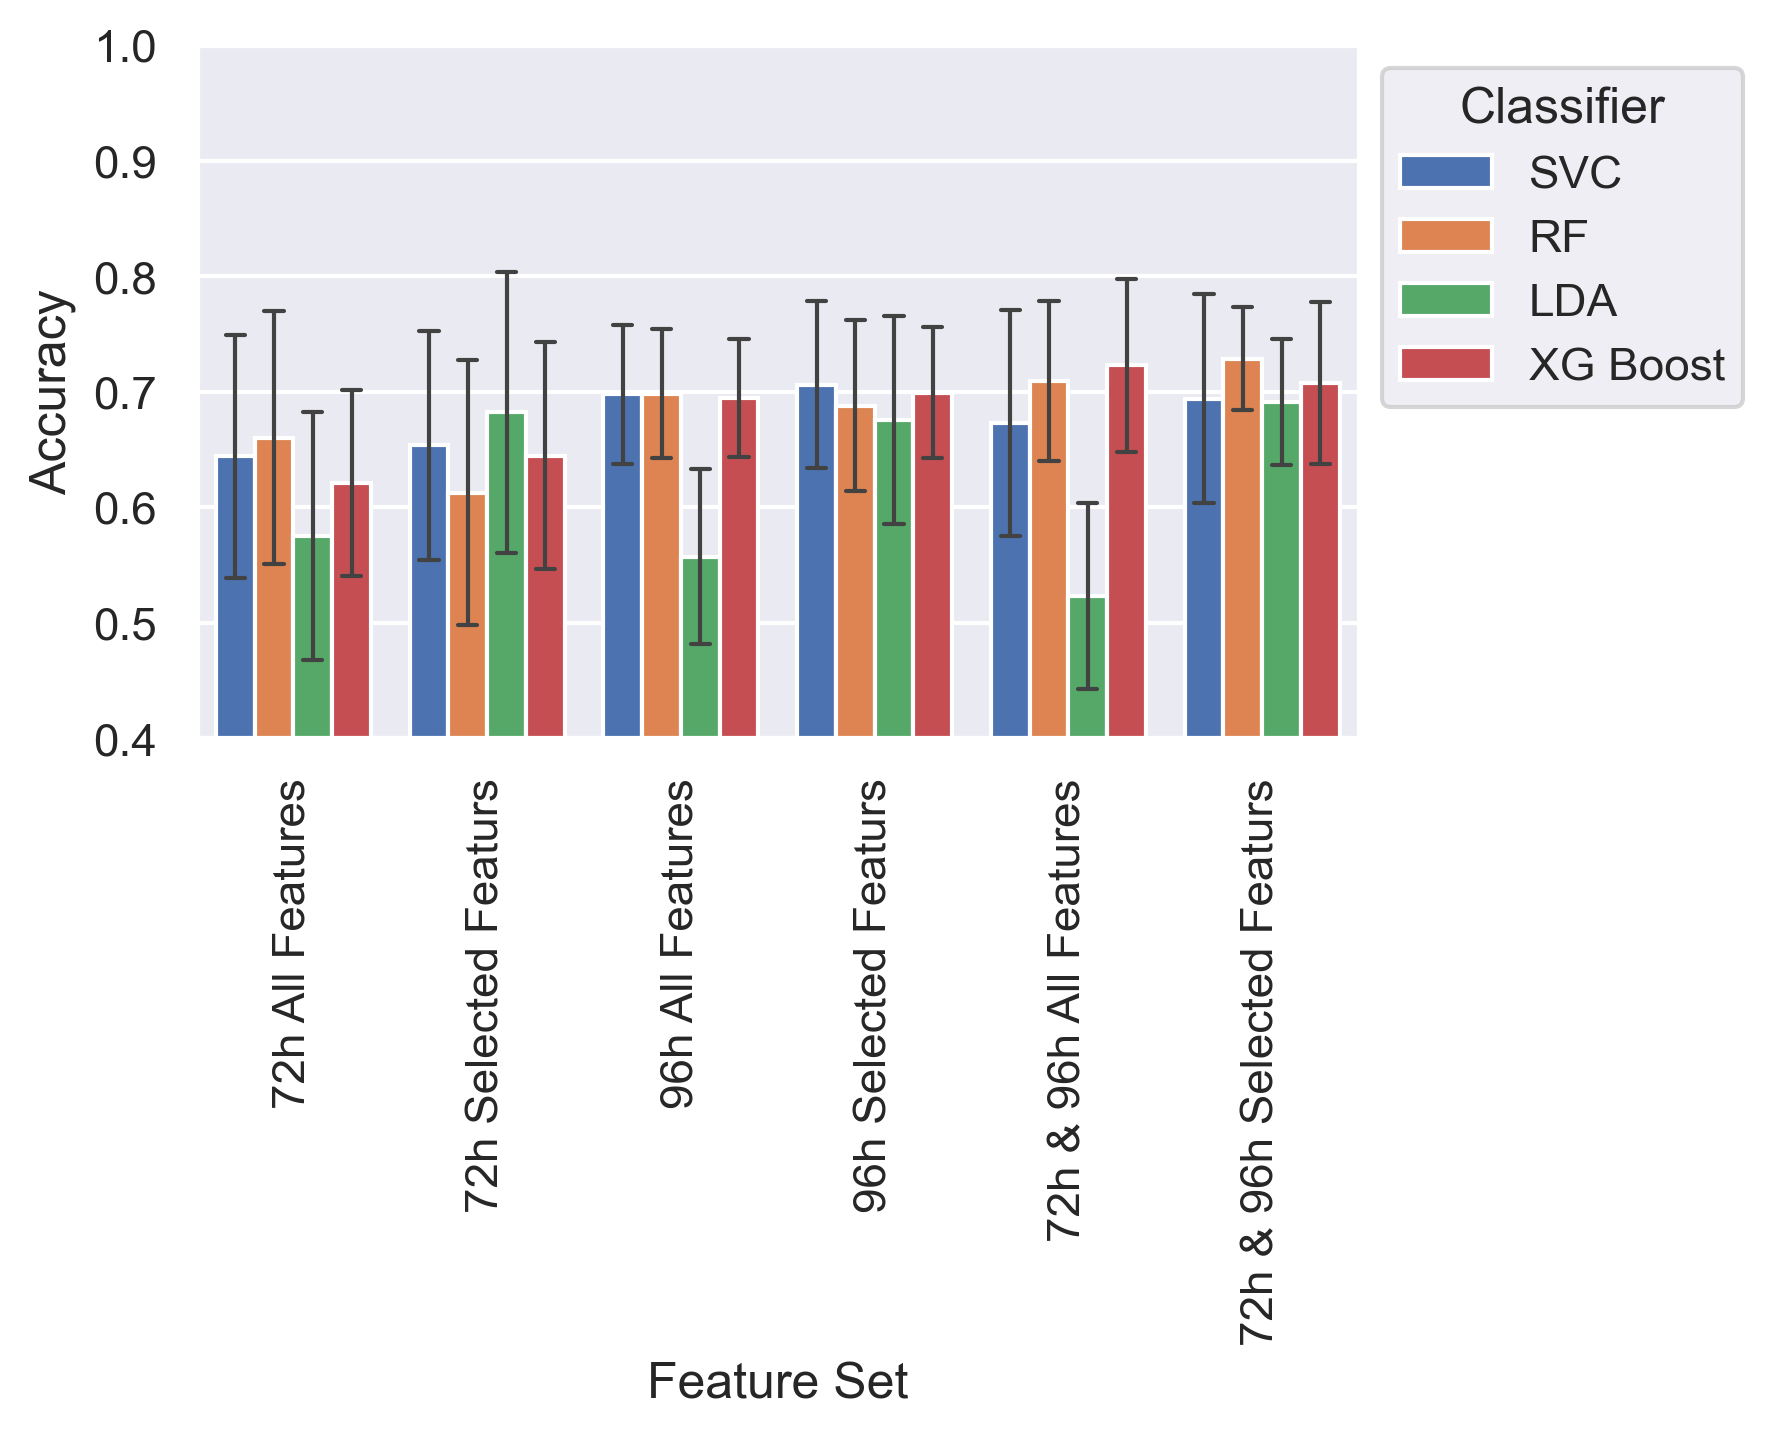

In [19]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

out_fig_2 = home_directory + "/" + r"Plots\Fig 2"

sns.set()
fig, ax = plt.subplots(figsize=(5,3))

ax = sns.barplot(all_classifier_results_df,y="Accuracy",x="Feature Set",hue="Classifier", ax = ax, width = 0.8,saturation=1,errorbar=("sd",1),capsize=0.1,errwidth=1)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_ylim([0.4,1])
plt.xticks(rotation=90)

#plt.savefig(f"{out_fig_2}/Morph Prediction.pdf", format="pdf", bbox_inches="tight")
plt.show()